# Visión por Computador - Práctica 2 - Deep Learning en Computer Vision

#### 12 puntos   |   Fecha de entrega: 15 de Diciembre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2425.ugr.es/

### Estudiante: <mark>Mohammed Lahssaini Nouijah</mark>

# <font color='blue'>**Ejercicio  3: Transfer Learning y fine-tuning con ResNet50 en el SPR X-Ray Age Prediction Challenge (3.5 points)**
<font color='blue'>En este ejercicio trabajaremos con el _SPR X-Ray Age Prediction Challenge_ de Kaggle (https://www.kaggle.com/competitions/spr-x-ray-age/data). Este dataset consta de $10 702$ radiografías de tórax, y el objetivo es predecir la edad de la persona a partir de la imagen de la radiografía. En esta ocasión, se emplearán $6 702$ imágenes para entrenamiento y $4 000$ para test. Las edades oscilan entre los 18 y los 89 años. Para facilitar el trabajo al alumnado se proporciona una versión procesada de los datos (con resolución $224\times224$, en lugar de $1024\times1024$, y empleando solo ejemplos para los cuales se tiene salida deseada (dado que, al tratarse de una challenge de kaggle, el conjunto de test está disponible pero sin etiquetar)). Estos datos se pueden acceder desde: https://drive.google.com/drive/folders/1hCWfTLs1w0h5kObl6NEIhEtH5VDmmCnj?usp=sharing (se debe emplear una cuenta de la UGR para acceder a dicha URL, y la información allí contenida (directorio `spr-x-ray-age`) se debe incluir en la carpeta `Colab Notebooks`).

<font color='blue'>Se debe emplear un $20\%$ de los datos de entrenamiento para validación, y el rendimiento debe ser evaluado, como mínimo, por medio de $MSE$, $MAE$ y $R^2$ _(coefficient of determination) score_. Se deben justificar las decisiones tomadas, como la elección de la función de pérdida. Del mismo modo, es necesario hacer un `summary()` de las arquitecturas empleadas en cada apartado, indicando qué parámetros/capas/bloques son entrenables y cuáles no lo son (es decir, en cada apartado es imprescindible destacar claramente qué arquitectura exacta se está utilizando, así como qué pesos se están entrenando y cuáles se están congelando).

<font color='blue'>Usaremos un modelo ResNet50 pre-entrenado en ImageNet, y tendremos que realizar los siguientes experimentos en relación a la estrategia de entrenamiento:

<font color='blue'>1. Partimos de ResNet50, adaptamos la cabecera (sustituyendo la cabecera anterior por *una única fully-connected* con el número de neuronas de salida adecuado), y reentrenamos (_from scratch_) la red entera para este nuevo problema. Es decir, partimos de pesos aleatorios para resolver este problema de regresión.

<font color='blue'>2. Partimos de ResNet50, adaptamos la cabecera (empleando la misma del apartado anterior), y entrenamos solo la cabecera incorporada. Es decir, ResNet50 se usa como un mero extractor de características, y los pesos que se entrenan son los de la nueva capa incorporada (manteniendo fijos/congelados todos los demás).  

<font color='blue'>3. Partimos de ResNet50, dejamos que fastai incorpore su cabecera por defecto (véase https://wandb.ai/capecape/imagenette_timm/reports/Checking-Out-the-New-fastai-timm-Integration--VmlldzoxOTMzNzMw o https://docs.fast.ai/vision.learner.html#head-and-model), y entrenamos solo la cabecera incorporada. Es decir, de nuevo, ResNet50 se usa como extractor de características, y los pesos que se entrenan son los de las nuevas capas incorporadas

<font color='blue'>4. Partimos de ResNet50, adaptamos la cabecera (puede ser la del apartado 3.2 o la del 3.3), y hacemos un ajuste fino de toda la red partiendo de los pesos de ResNet50 (preentrenada en ImageNet).



<font color='blue'>Es importante remarcar que estamos intentando resolver un problema de regresión por medio de la reutilización de un modelo pre-entrenado en un problema de clasificación (ImageNet). ¿Tiene sentido hacerlo? ¿Por qué nos sirven pesos entrenados en clasificación para un problema de regresión? ¿No son, acaso, problemáticas muy diferentes?

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

fastcore version 1.7.22 installed
fastai version 2.7.18 installed


In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [ ]:
# defining the paths to images and labels
train_folder = 'gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train'
test_folder = 'gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/test'
csv_path = 'gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/All_labels.csv'

In [ ]:
if os.path.exists(csv_path):
    print("CSV File exists!")
    # reading the labels dataframe
    df = pd.read_csv(csv_path, dtype=float, index_col=0)
    print(f'Dataframe shape: {df.shape}')
else:
    print("File does not exist.")

CSV File exists!
Dataframe shape: (10702, 1)


In [ ]:
# defining the dataset paths
train_path = Path(train_folder)
test_path = Path(test_folder)

# reading the folders looking for images
train_files = get_image_files(train_path)
test_files = sorted(get_image_files(test_path))

print(f'{len(train_files)} files were found for training and {len(test_files)} files were found for test')

1413 files were found for training and 1665 files were found for test


Age varies from 18.0 to 89.0



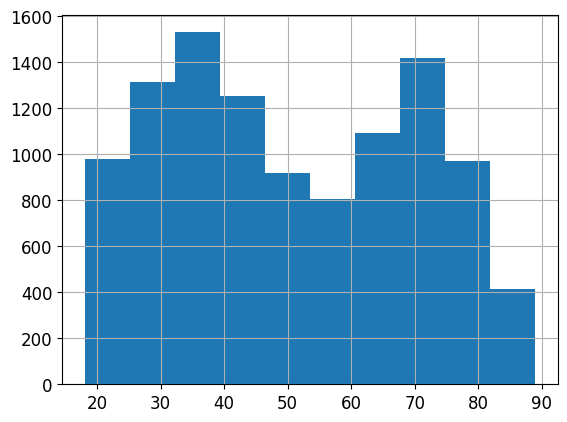

In [ ]:
print(f'Age varies from {df.age.min()} to {df.age.max()}\n')
_=df.age.hist()

In [ ]:
# function used to retun the label from an image
def label_func(file):
    # takes the file's base name w/o the extension
    basename = int(os.path.basename(str(file)).split('.')[0])

    # searches for the label
    label = int(df.age[basename])

    return label

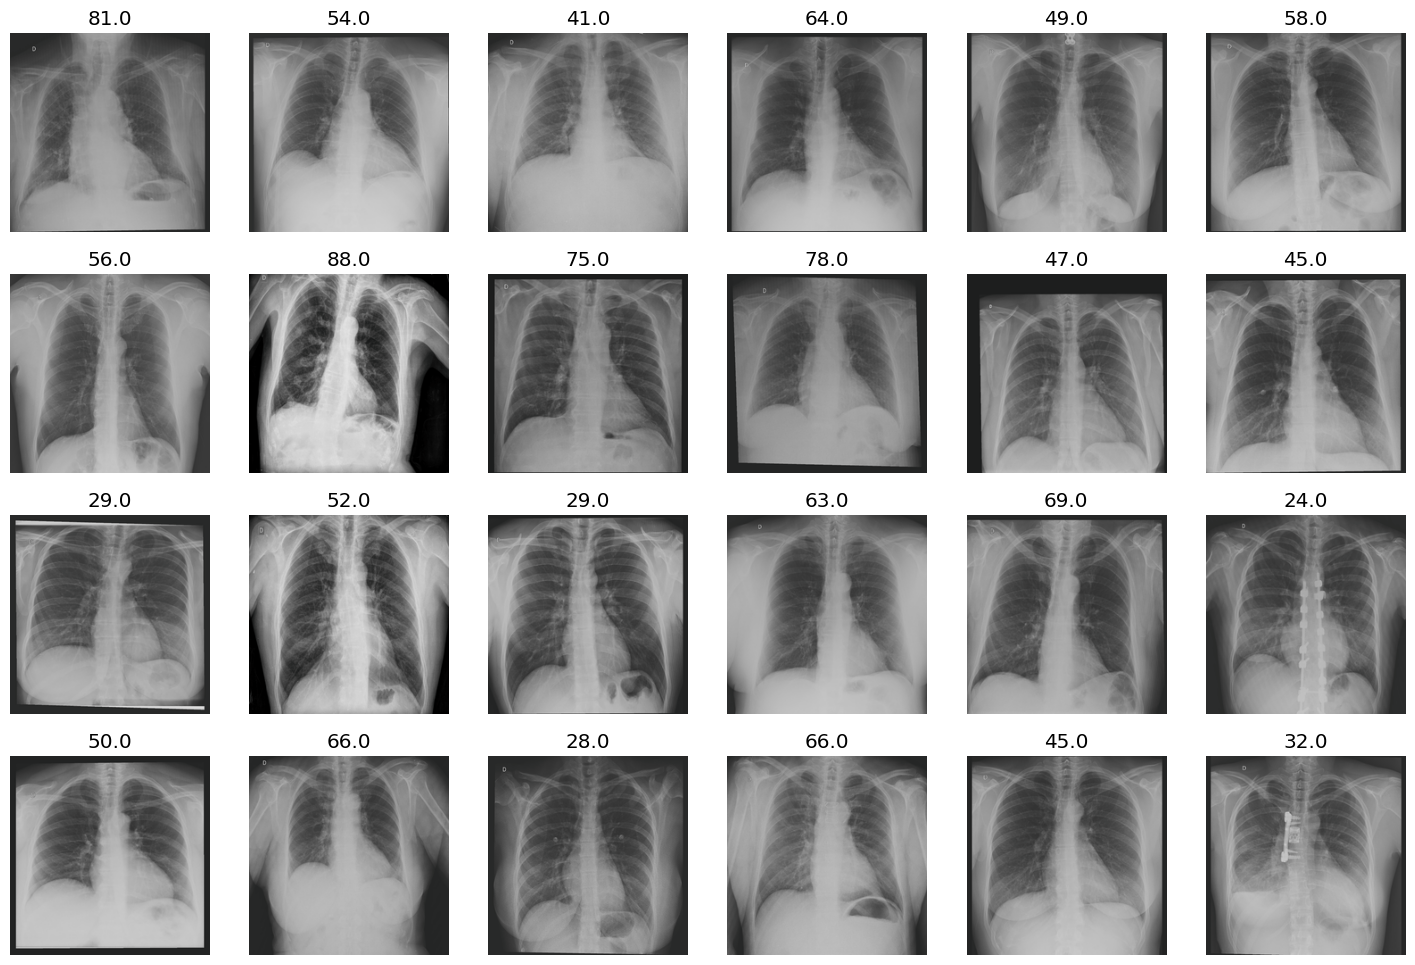

In [ ]:
# defines the image dataloader
dtblk = DataBlock(
      blocks=(ImageBlock, RegressionBlock),  # Bloques para imágenes (entrada) y valores continuos (salida)
      get_items=get_image_files,  # Función para obtener archivos de imagen
      get_y=label_func,
      splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Dividir datos en entrenamiento y validación
      item_tfms=[Resize(224)],  # Redimensionar todas las imágenes a 224x224
      batch_tfms=[Normalize.from_stats(*imagenet_stats)]  # Normalizar usando estadísticas de ImageNet
)

dls = dtblk.dataloaders(train_path, bs=64)

# shows some samples
dls.show_batch(max_n=24)

In [ ]:
from torchvision.models import resnet50

## <font color='blue'>3.1 Entrenamos todo ResNet50 _from scratch_, ajustando la cabecera para este problema.

### **Apartado 1: Reentrenar ResNet50 desde Cero**
En este apartado:
1. Partimos de una red ResNet50 con pesos aleatorios, es decir, no utilizamos los pesos preentrenados en ImageNet.
2. Sustituimos la cabecera original de ResNet50 por una cabecera personalizada diseñada para un problema de regresión.
3. Entrenamos todos los parámetros de la red, desde los bloques convolucionales hasta la cabecera, utilizando nuestros datos.
4. Evaluamos el rendimiento del modelo utilizando las métricas requeridas:
   - **MSE (Mean Squared Error)**.
   - **MAE (Mean Absolute Error)**.
   - **RMSE (Root Mean Squared Error)**.
   - **R² (Coefficient of Determination)**.
   
Este enfoque tiene como objetivo permitir que la red aprenda características específicas del dominio, sin heredar información de problemas previos como clasificación de imágenes.


### **Diseño del Modelo y Cabecera**
1. **Base del Modelo**:
   - Usamos ResNet50 con pesos aleatorios para que toda la red aprenda desde cero.
   - Esto implica que los bloques convolucionales no tienen ninguna información previa, lo que puede dificultar el aprendizaje inicial.

2. **Cabecera Personalizada**:
   - La cabecera de la red se reemplaza por una secuencia de capas totalmente conectadas:
     - `Flatten()`: Aplana las características extraídas por los bloques convolucionales.
     - `Linear(2048, 512)`: Reduce la dimensionalidad a 512.
     - `ReLU()`: Introduce no linealidad.
     - `Linear(512, 1)`: Genera la predicción final de edad.
   - Este diseño es simple, pero suficiente para tareas de regresión.


In [ ]:
# Crear la cabecera personalizada como nn.Sequential
def create_custom_head():
    return nn.Sequential(
        nn.Flatten(),  # Aplanar la salida convolucional
        nn.Linear(2048, 512),  # Primera capa totalmente conectada
        nn.ReLU(),  # Activación no lineal
        nn.Linear(512, 1)  # Salida final (un único valor para regresión)
    )


# Crear el modelo completo
def create_resnet50_scratch():
    model = resnet50(weights=None)  # Sin pesos preentrenados
    model.fc = create_custom_head()  # Reemplazar la cabecera con la personalizada
    return model

# Instanciar el modelo
model_scratch = create_resnet50_scratch()


### **Configuración del Learner**
1. **Modelo**:
   - Usamos ResNet50 con pesos aleatorios y una cabecera personalizada.
   
2. **Función de Pérdida**:
   - Elegimos **MSELoss**, adecuada para problemas de regresión.

3. **Métricas**:
   - **MAE** y **RMSE**: Proporcionan información sobre el error promedio y su raíz cuadrada, respectivamente.

4. **Optimización**:
   - Utilizamos **Adam** como función de optimización.


In [ ]:
# Configurar el Learner
learn_scratch = Learner(
    dls,
    model_scratch,
    opt_func=Adam,  # Usar Adam como optimizador
    loss_func=nn.MSELoss(),  # Función de pérdida para regresión
    metrics=[mae, rmse]  # Métricas: MAE y RMSE
)

# Mostrar un resumen del modelo
learn_scratch.summary()


ResNet (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      True      
BatchNorm2d                            

### **Búsqueda del Mejor Learning Rate**
1. Utilizamos `lr_find()` para identificar el rango óptimo de tasas de aprendizaje.
2. Este método permite un entrenamiento más eficiente y reduce el riesgo de elegir un `Learning Rate` inapropiado.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explici

Learning Rate sugerido: valley=0.0006918309954926372


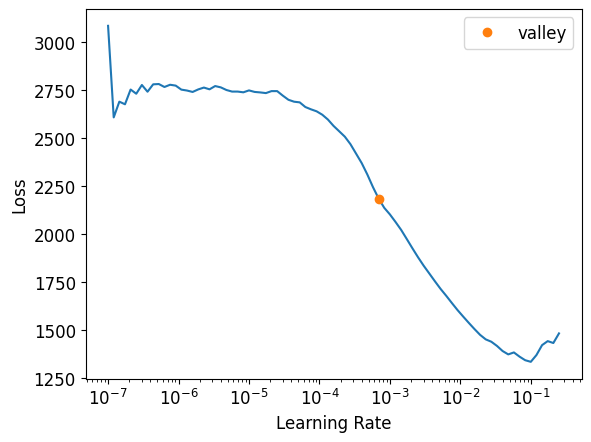

In [ ]:
# Buscar el mejor Learning Rate
lr_scratch = learn_scratch.lr_find()
print(f"Learning Rate sugerido: valley={lr_scratch.valley}")


### **Entrenamiento del Modelo**
1. **Optimización**:
   - Usamos el optimizador **Adam** por su capacidad de manejar diferentes tasas de aprendizaje para cada parámetro.
   
2. **Función de Pérdida**:
   - **MSELoss**: Es apropiada para regresión, ya que penaliza más los errores grandes.

3. **Callbacks**:
   - **SaveModelCallback**: Guarda el mejor modelo durante el entrenamiento.
   - **ShowGraphCallback**: Muestra gráficos de métricas y pérdida.
   - **EarlyStoppingCallback**: Detiene el entrenamiento si no hay mejoras significativas en la pérdida de validación.

4. **Número de Épocas**:
   - Entrenamos por 25 épocas, con un `Learning Rate` sugerido por `lr_find()`.


epoch,train_loss,valid_loss,mae,_rmse,time
0,2457.242920,2374.409912,44.967930,48.728130,00:14
1,1818.942993,358.471069,16.313305,18.927719,00:14
2,1189.008179,2853.356934,41.675220,53.165138,00:14
3,869.373352,363.941833,16.794018,18.971235,00:14
4,690.981506,353.626038,16.456881,18.813553,00:14
5,582.348816,359.721893,16.030405,18.952129,00:16
6,512.353394,352.749634,16.403820,18.761595,00:15
7,467.255676,355.910431,16.601988,18.858139,00:14
8,434.995453,352.582397,16.256865,18.747248,00:14
9,413.901703,352.344788,16.330002,18.765221,00:14


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Better model found at epoch 0 with valid_loss value: 2374.409912109375.


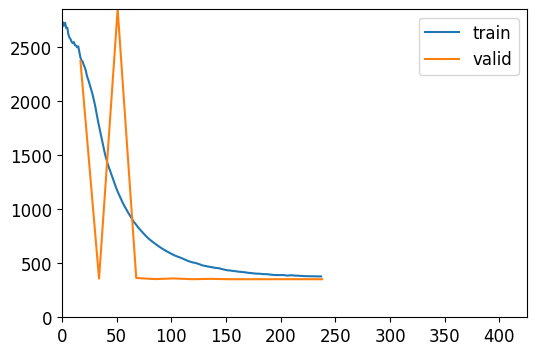

Better model found at epoch 1 with valid_loss value: 358.4710693359375.
Better model found at epoch 4 with valid_loss value: 353.62603759765625.
Better model found at epoch 6 with valid_loss value: 352.7496337890625.
Better model found at epoch 8 with valid_loss value: 352.5823974609375.
Better model found at epoch 9 with valid_loss value: 352.34478759765625.
No improvement since epoch 9: early stopping


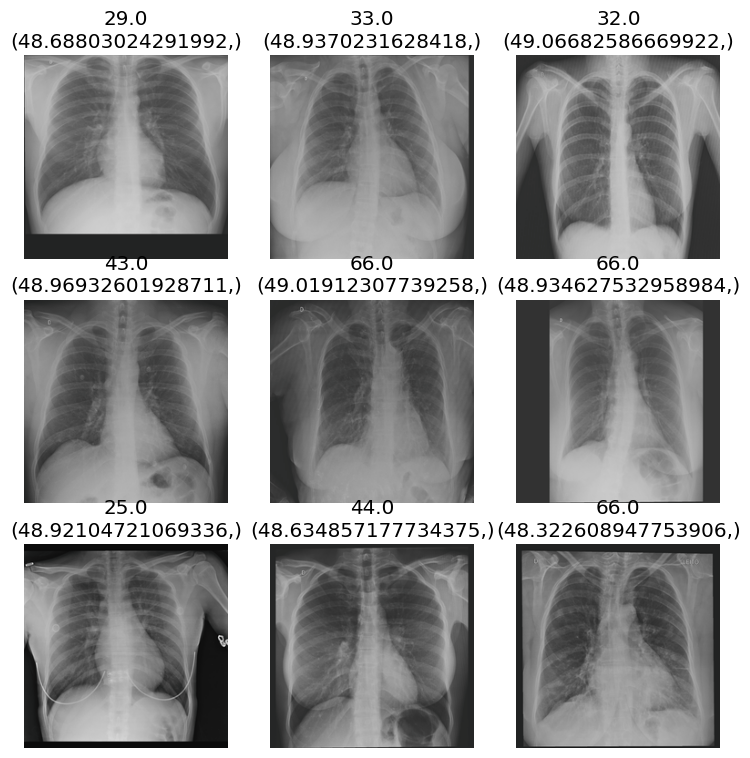

In [ ]:
# Configurar los callbacks
cbs = [
    SaveModelCallback(),  # Guardar el mejor modelo
    ShowGraphCallback(),  # Mostrar gráficos del entrenamiento
    EarlyStoppingCallback(monitor='valid_loss', patience=5)  # Detener si no hay mejora
]

# Entrenar el modelo
learn_scratch.fit_one_cycle(
    25,  # Número de épocas
    lr_max=slice(lr_scratch.valley / 10, lr_scratch.valley),  # Usar el rango del learning rate sugerido
    cbs=cbs
)

# Mostrar resultados del entrenamiento
learn_scratch.show_results()


### **Análisis de Resultados**
- Evaluamos el modelo con las siguientes métricas:
  - **MSE**: Error cuadrático medio, indica el error promedio.
  - **MAE**: Error absoluto medio, mide el error promedio sin penalizar grandes desviaciones.
  - **RMSE**: Raíz del error cuadrático medio, similar al MSE pero en la misma escala que los datos.
  - **R²**: Coeficiente de determinación, mide qué tan bien se ajustan las predicciones a los datos reales.


In [ ]:
results = learn_scratch.validate()

mse_final = results[0]  # MSE
mae_final = results[1]  # MAE
rmse_final = results[2]  # RMSE

print(f"MSE Final: {mse_final:.4f}")
print(f"MAE Final: {mae_final:.4f}")
print(f"RMSE Final: {rmse_final:.4f}")

preds, targs = learn_scratch.get_preds()
r2_final = r2_score(targs.numpy(), preds.numpy())

print(f"R² Final (Validation Set): {r2_final:.4f}")


MSE Final: 352.3448
MAE Final: 16.3300
RMSE Final: 18.7652


R² Final (Validation Set): 0.0005


**Resultados:**
- MSE: 352.3448
- MAE: 16.3300
- RMSE: 18.7652
- R²: 0.0005

**Comentarios:**
- Entrenar ResNet50 desde cero logra un rendimiento aceptable, pero este enfoque no aprovecha características preentrenadas.
- La red necesita aprender todo desde el principio, lo que puede ser ineficiente en términos de recursos computacionales y tiempo.
- R² cercano a 0 sugiere que el modelo apenas captura las variaciones en los datos.

**Ventajas:**
- Modelo completamente adaptado al problema.
- Independencia de cualquier información previa.

**Desventajas:**
- Mayor complejidad computacional.
- Riesgo de sobreajuste sin suficiente cantidad de datos.

---


## <font color='blue'>3.2. ResNet50 se usa como extractor de características: Entrenamos solo la cabecera incorporada.



2. Partimos de ResNet50, adaptamos la cabecera (empleando la misma del apartado anterior), y entrenamos solo la cabecera incorporada. Es decir, ResNet50 se usa como un mero extractor de características, y los pesos que se entrenan son los de la nueva capa incorporada (manteniendo fijos/congelados todos los demás).



### **Apartado 2: Entrenar Solo la Cabecera de ResNet50**
En este apartado:
1. Partimos de una red ResNet50 preentrenada en ImageNet.
2. Congelamos los bloques convolucionales de ResNet50, manteniendo sus pesos fijos.
3. Entrenamos únicamente una cabecera personalizada diseñada para predecir la edad.
4. Evaluamos el rendimiento del modelo utilizando las métricas requeridas.

Este enfoque se basa en usar ResNet50 como un **extractor de características**, dejando que solo la cabecera aprenda los patrones específicos del problema.


### **Uso de ResNet50 como Extractor de Características**
1. **Congelación de Parámetros**:
   - Los bloques convolucionales no se actualan durante el entrenamiento.
   - Esto permite aprovechar los patrones generales aprendidos en ImageNet.
   
2. **Ventajas**:
   - Reduce significativamente el número de parámetros a entrenar.
   - Requiere menos recursos computacionales y tiempo de entrenamiento.

3. **Limitaciones**:
   - Si las características aprendidas por ResNet50 no son relevantes para el problema, el modelo no podrá capturar los patrones deseados.


### **Diseño de la Cabecera Personalizada**
- La cabecera es la misma que en el Apartado 1:
  - `Flatten()`: Aplana las características.
  - `Linear(2048, 512)`: Reduce la dimensionalidad a 512.
  - `ReLU()`: Introduce no linealidad.
  - `Linear(512, 1)`: Genera la predicción de edad.
- No se realizan cambios en la cabecera para mantener consistencia en la evaluación.


##### **Congelación de Parámetros**
- Congelamos todos los bloques convolucionales de ResNet50 para que sirvan como extractor de características.
- Permitimos que únicamente los parámetros de la cabecera sean entrenables.


In [ ]:
# Crear el modelo ResNet50 con pesos preentrenados y cabecera personalizada
def create_resnet50_head_train():
    model = resnet50(weights='IMAGENET1K_V1')  # Pesos preentrenados en ImageNet
    model.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Linear(512, 1)
    )
    return model

# Instanciar el modelo
model_head_train = create_resnet50_head_train()

# Congelar todos los bloques convolucionales
for param in model_head_train.parameters():
    param.requires_grad = False  # Congelar todos los parámetros

# Hacer entrenable solo la cabecera
for param in model_head_train.fc.parameters():
    param.requires_grad = True


### Configuración del Learner

Aquí configuramos el `Learner`, que actúa como la interfaz principal para el entrenamiento y evaluación del modelo.

#### Detalles:
1. **Modelo**: Usamos el modelo `model_head_train` configurado previamente.
2. **Función de Pérdida**:
   - Usamos `nn.MSELoss` para calcular el error cuadrático medio, una métrica estándar para problemas de regresión.
3. **Métricas**:
   - **MAE** (Mean Absolute Error): Para medir el error promedio absoluto.
   - **RMSE** (Root Mean Squared Error): Para penalizar errores grandes de forma más severa.
4. **Resumen del Modelo**:
   - Verificamos qué parámetros son entrenables (solo la cabecera en este caso).


In [ ]:
# Configurar el Learner
learn_head = Learner(
    dls,
    model_head_train,
    opt_func=Adam,
    loss_func=nn.MSELoss(),
    metrics=[mae, rmse]
)

# Mostrar un resumen para verificar qué parámetros son entrenables
learn_head.summary()


ResNet (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        False     
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                            

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explici

Learning Rate sugerido: valley=0.0020892962347716093


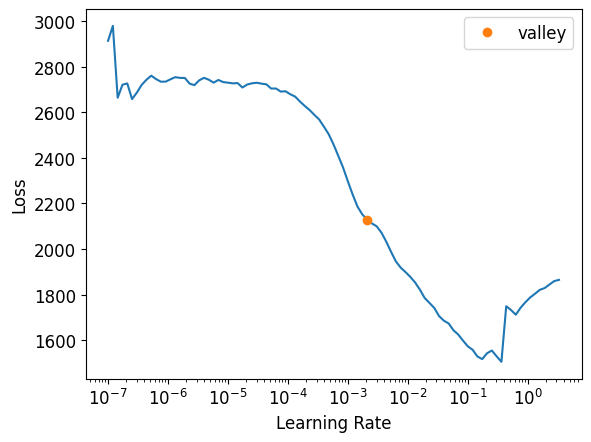

In [ ]:
# Buscar el mejor Learning Rate para la cabecera
lr_head = learn_head.lr_find()
print(f"Learning Rate sugerido: valley={lr_head.valley}")


### **Entrenamiento del Modelo**
1. **Optimización**:
   - El optimizador **Adam** se utiliza con los mismos argumentos que en el Apartado 1.

2. **Función de Pérdida**:
   - **MSELoss**, adecuada para regresión.

3. **Congelación**:
   - Todos los bloques convolucionales están congelados.
   - Solo se entrenan los parámetros de la cabecera.

4. **Callbacks**:
   - **SaveModelCallback**.
   - **ShowGraphCallback**.
   - **EarlyStoppingCallback**.


epoch,train_loss,valid_loss,mae,_rmse,time
0,2327.642334,1652.770142,36.032860,40.765499,00:10
1,1513.787109,434.638947,18.693167,21.756107,00:11
2,1078.421631,383.336395,17.714670,20.733959,00:10
3,821.066650,413.769592,19.023382,21.780304,00:09
4,669.860352,384.807831,18.099669,20.934752,00:10
5,577.128174,392.600555,18.317659,21.020681,00:10
6,516.737976,380.479431,17.140102,20.433695,00:08
7,476.529938,386.333405,18.059290,20.602812,00:10
8,448.372833,371.112030,17.164917,20.015102,00:10
9,429.126678,370.226898,17.348150,19.935602,00:09


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Better model found at epoch 0 with valid_loss value: 1652.7701416015625.


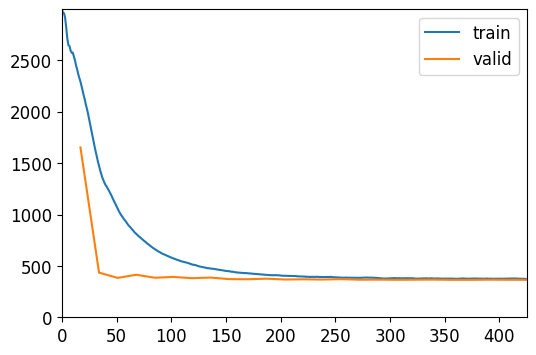

Better model found at epoch 1 with valid_loss value: 434.6389465332031.
Better model found at epoch 2 with valid_loss value: 383.3363952636719.
Better model found at epoch 6 with valid_loss value: 380.47943115234375.
Better model found at epoch 8 with valid_loss value: 371.1120300292969.
Better model found at epoch 9 with valid_loss value: 370.2268981933594.
Better model found at epoch 11 with valid_loss value: 367.569091796875.
Better model found at epoch 13 with valid_loss value: 367.1155700683594.
Better model found at epoch 15 with valid_loss value: 365.5139465332031.
Better model found at epoch 17 with valid_loss value: 364.80419921875.
Better model found at epoch 20 with valid_loss value: 364.3321533203125.


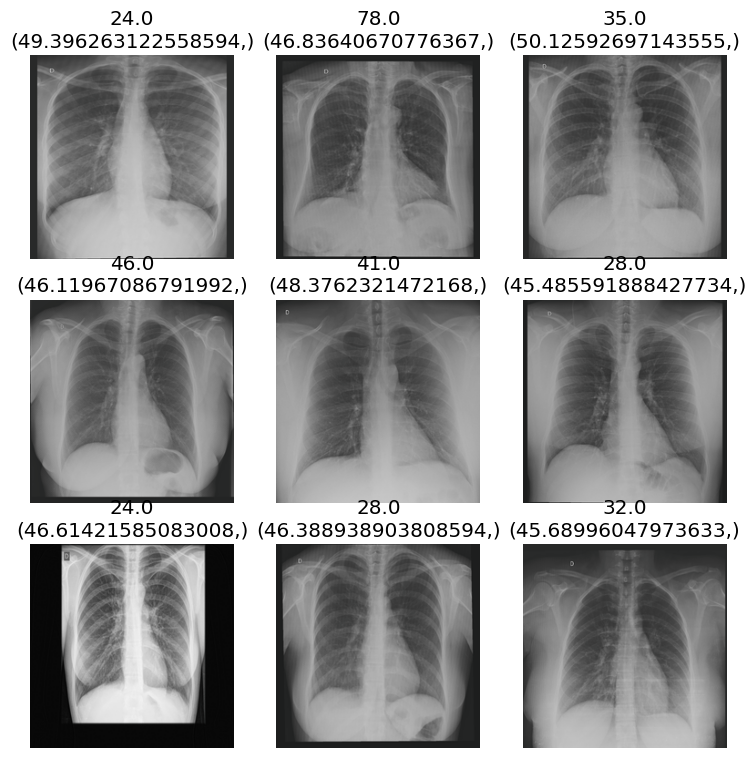

In [ ]:
# Configurar los callbacks
cbs = [
    SaveModelCallback(),  # Guardar el mejor modelo
    ShowGraphCallback(),  # Mostrar gráficos
    EarlyStoppingCallback(monitor='valid_loss', patience=5)  # Detener si no mejora
]

# Entrenar solo la cabecera
learn_head.fit_one_cycle(
    25,  # Número de épocas
    lr_max=slice(lr_head.valley / 10, lr_head.valley),  # Learning Rate sugerido
    cbs=cbs
)

# Mostrar resultados del entrenamiento
learn_head.show_results()


### **Análisis de Resultados**
- Evaluamos el modelo con las siguientes métricas:
  - **MSE**: Error cuadrático medio, indica el error promedio.
  - **MAE**: Error absoluto medio, mide el error promedio sin penalizar grandes desviaciones.
  - **RMSE**: Raíz del error cuadrático medio, similar al MSE pero en la misma escala que los datos.
  - **R²**: Coeficiente de determinación, mide qué tan bien se ajustan las predicciones a los datos reales.


In [ ]:
# Validar en el conjunto de validación
preds, targs = learn_head.get_preds()
results = learn_head.validate()

# Extraer métricas
mse_final = results[0]  # MSE
mae_final = results[1]  # MAE
rmse_final = results[2]  # RMSE
r2_final = r2_score(targs.numpy(), preds.numpy())  # R²

# Imprimir resultados finales
print(f"MSE Final: {mse_final:.4f}")
print(f"MAE Final: {mae_final:.4f}")
print(f"RMSE Final: {rmse_final:.4f}")
print(f"R² Final (Validation Set): {r2_final:.4f}")


MSE Final: 364.3322
MAE Final: 16.8298
RMSE Final: 19.3324
R² Final (Validation Set): -0.0609


**Resultados:**
- MSE: 364.3322
- MAE: 16.8298
- RMSE: 19.3324
- R²: -0.0609

**Comentarios:**
- El peor rendimiento entre los apartados. Esto podría deberse a que los bloques convolucionales preentrenados no están optimizados para este problema de regresión.
- La cabecera personalizada no logra compensar la falta de ajuste de los bloques convolucionales.

**Ventajas:**
- Menor costo computacional al entrenar solo la cabecera.

**Desventajas:**
- Sin ajuste de los bloques convolucionales, el modelo puede carecer de capacidad para aprender características específicas del problema.
- R² negativo indica que el modelo predice peor que una media constante.
---


Métricas Finales
MSE (Mean Squared Error): 366.3577

Representa el error promedio cuadrático entre las predicciones y las etiquetas reales. Un valor más bajo es mejor.
Este valor indica un error significativo en las predicciones, lo que sugiere que el modelo no está capturando adecuadamente las relaciones en los datos.
MAE (Mean Absolute Error): 17.0195

Muestra el error promedio absoluto. A diferencia del MSE, no penaliza tanto los errores grandes.
Un MAE de 17.02 indica que, en promedio, el modelo predice edades con un error de ±17 años.
RMSE (Root Mean Squared Error): 19.5509

Penaliza más los errores grandes que el MAE. Similar al MSE, pero en la misma escala que las etiquetas.
Este valor refuerza la conclusión de que los errores son significativos.
R² (Coefficient of Determination): -0.0850

Un valor negativo indica que el modelo es peor que un modelo trivial que siempre predice la media de las etiquetas. Esto sugiere que el modelo no ha aprendido patrones útiles para el problema.
Interpretación de Resultados
Cabecera Entrenada vs Bloques Convolucionales Congelados:

El hecho de congelar los bloques convolucionales y entrenar solo la cabecera parece haber limitado la capacidad del modelo para adaptarse al problema de regresión.
Las características extraídas de ResNet50 no parecen ser suficientemente relevantes para predecir la edad a partir de radiografías.
Comparación con el Apartado 1:

MSE y RMSE son significativamente peores que en el Apartado 1, donde entrenamos todos los pesos "from scratch".
El R² negativo destaca que este enfoque no logra capturar patrones significativos, posiblemente debido a la falta de ajuste fino en los bloques convolucionales.
Posibles Razones del Bajo Rendimiento:

Las características aprendidas por ResNet50 en ImageNet no son directamente transferibles a este problema específico.
La cantidad de datos y su distribución puede requerir ajustes en los bloques convolucionales, no solo en la cabecera.


## <font color='blue'>3.3. ResNet50 se usa como extractor de características: Entrenamos solo la cabecera incorporada por defecto por fastai.



### **Apartado 3: ResNet50 con Cabecera de fastai**
En este apartado:
1. Usamos ResNet50 preentrenada en ImageNet, congelando todos sus bloques convolucionales.
2. Dejamos que `fastai` incorpore automáticamente una cabecera por defecto adecuada para regresión.
3. Entrenamos únicamente las capas de la cabecera generada por `fastai`.
4. Evaluamos el rendimiento del modelo con las mismas métricas: **MSE**, **MAE**, **RMSE** y **R²**.


### **Configurar el Modelo con Cabecera de fastai**
- Usaremos la función `vision_learner` de `fastai`, que genera automáticamente una cabecera adecuada para problemas de clasificación o regresión.
- Este modelo utilizará los bloques convolucionales de ResNet50 como extractor de características.
- La cabecera será ajustada para nuestro problema de predicción de la edad.


In [ ]:
# Crear el Learner con la cabecera por defecto de fastai
learn_fastai_head = vision_learner(
    dls,
    resnet50,
    metrics=[mae, rmse],
    loss_func=nn.MSELoss()
)

### **Congelación de Parámetros**
- Congelamos todos los bloques convolucionales de ResNet50, manteniendo sus pesos preentrenados sin cambios.
- Solo las capas añadidas por `fastai` en la cabecera serán entrenadas.


In [ ]:


# Congelar los bloques convolucionales
learn_fastai_head.freeze()

# Mostrar el resumen del modelo para verificar qué parámetros son entrenables
learn_fastai_head.summary()


Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

### **Búsqueda del Mejor Learning Rate**
- Usamos la función `lr_find` para identificar el mejor rango de learning rate.
- Esto garantiza un entrenamiento eficiente y estable.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explici

Learning Rate sugerido: valley=0.03981071710586548


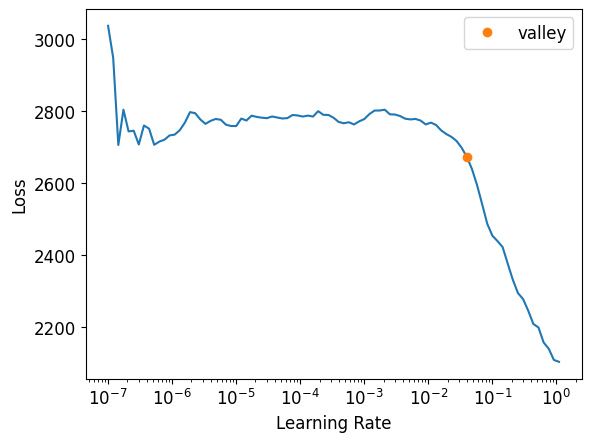

In [ ]:
# Buscar el mejor Learning Rate
lr_fastai_head = learn_fastai_head.lr_find()
print(f"Learning Rate sugerido: valley={lr_fastai_head.valley}")



### **Entrenamiento del Modelo**


epoch,train_loss,valid_loss,mae,_rmse,time
0,2729.507568,2557.032959,46.949200,50.489712,00:12
1,2598.983398,2119.936768,42.018372,46.014458,00:12
2,1987.921997,421.930603,18.321795,21.108852,00:12
3,1432.326172,438.026398,16.446688,20.307095,00:12
4,1086.487793,379.969940,16.855251,19.824488,00:11
5,860.823853,364.791779,16.318586,19.200073,00:12
6,711.134949,355.185730,16.119162,18.654081,00:14
7,608.867432,355.911316,16.504860,18.802486,00:13
8,538.658997,353.524384,16.134056,18.613192,00:12
9,490.721252,368.020325,15.969200,19.111496,00:12


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Better model found at epoch 0 with valid_loss value: 2557.032958984375.


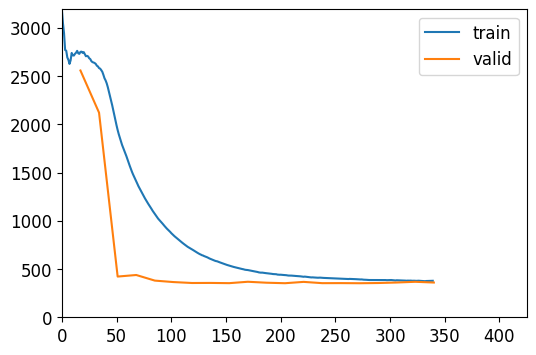

Better model found at epoch 1 with valid_loss value: 2119.936767578125.
Better model found at epoch 2 with valid_loss value: 421.93060302734375.
Better model found at epoch 4 with valid_loss value: 379.9699401855469.
Better model found at epoch 5 with valid_loss value: 364.7917785644531.
Better model found at epoch 6 with valid_loss value: 355.18572998046875.
Better model found at epoch 8 with valid_loss value: 353.5243835449219.
Better model found at epoch 11 with valid_loss value: 352.9574890136719.
Better model found at epoch 15 with valid_loss value: 352.75518798828125.
No improvement since epoch 15: early stopping


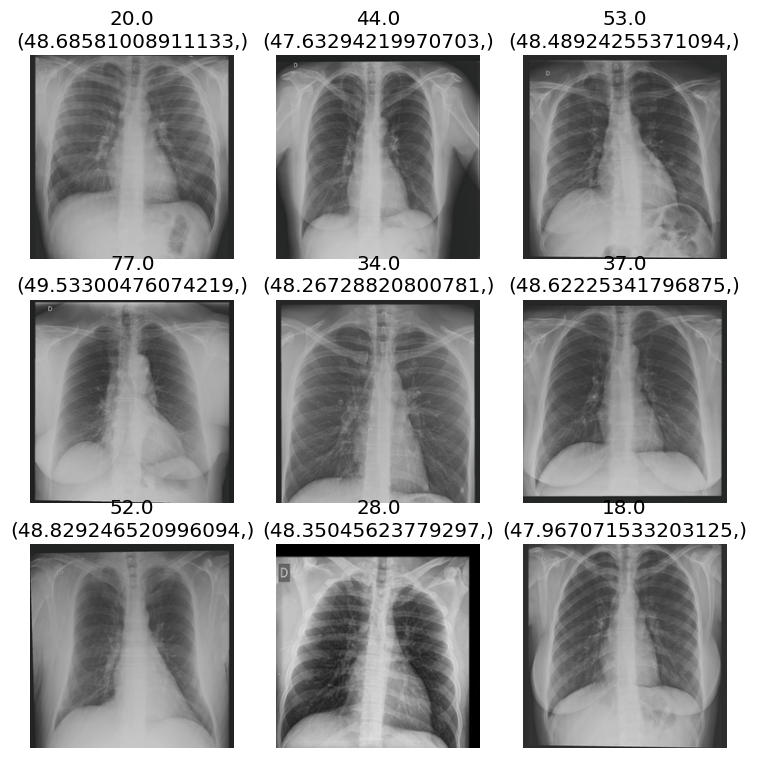

In [ ]:
# Configurar los callbacks
cbs = [
    SaveModelCallback(),  # Guardar el mejor modelo
    ShowGraphCallback(),  # Mostrar gráficos del entrenamiento
    EarlyStoppingCallback(monitor='valid_loss', patience=5)  # Detener si no hay mejora
]

# Entrenar el modelo
learn_fastai_head.fit_one_cycle(
    25,  # Número de épocas
    lr_max=slice(lr_fastai_head.valley / 10, lr_fastai_head.valley),  # Learning Rate sugerido
    cbs=cbs
)

# Mostrar resultados del entrenamiento
learn_fastai_head.show_results()


### **Análisis de Resultados**
- Evaluamos el modelo con las siguientes métricas:
  - **MSE**: Error cuadrático medio, indica el error promedio.
  - **MAE**: Error absoluto medio, mide el error promedio sin penalizar grandes desviaciones.
  - **RMSE**: Raíz del error cuadrático medio, similar al MSE pero en la misma escala que los datos.
  - **R²**: Coeficiente de determinación, mide qué tan bien se ajustan las predicciones a los datos reales.


In [ ]:
# Validar en el conjunto de validación
preds, targs = learn_fastai_head.get_preds()
results = learn_fastai_head.validate()

# Extraer métricas
mse_final = results[0]  # MSE
mae_final = results[1]  # MAE
rmse_final = results[2]  # RMSE
r2_final = r2_score(targs.numpy(), preds.numpy())  # R²

# Imprimir resultados finales
print(f"MSE Final: {mse_final:.4f}")
print(f"MAE Final: {mae_final:.4f}")
print(f"RMSE Final: {rmse_final:.4f}")
print(f"R² Final (Validation Set): {r2_final:.4f}")


MSE Final: 352.7552
MAE Final: 16.3812
RMSE Final: 18.8807
R² Final (Validation Set): -0.0119


**Resultados:**
- MSE: 352.7552
- MAE: 16.3812
- RMSE: 18.8807
- R²: -0.0119

**Comentarios:**
- Rendimiento ligeramente mejor que el Apartado 2, pero aún lejos del óptimo.
- La cabecera por defecto de `fastai` ofrece una ventaja frente a la personalizada en este caso.
- R² sigue siendo negativo, lo que sugiere una falta de ajuste.

**Ventajas:**
- Simplicidad al utilizar la cabecera generada automáticamente por `fastai`.
- Menor costo computacional que ajustar toda la red.

**Desventajas:**
- La falta de ajuste fino limita la capacidad del modelo para capturar patrones específicos del problema.
---


## <font color='blue'>3.4. Hacemos un ajuste fino (fine-tuning) de toda la red partiendo de los pesos de ImageNet.

4. Partimos de ResNet50, adaptamos la cabecera (puede ser la del apartado 3.2 o la del 3.3), y hacemos un ajuste fino de toda la red partiendo de los pesos de ResNet50 (preentrenada en ImageNet).

### **Apartado 4: Fine-tuning de ResNet50**
1. Se parte de ResNet50 preentrenada en ImageNet.
2. Se desbloquean los bloques convolucionales para entrenarlos junto con la cabecera.
3. Se realiza un ajuste fino (fine-tuning) para optimizar la red completa.
4. Este método permite adaptar las características generales aprendidas en ImageNet al problema específico de regresión.


### **Preparación del Modelo**
- Reutilizamos el modelo configurado en el Apartado 3.
- Descongelamos los bloques convolucionales para entrenarlos.


In [ ]:
# Descongelar todos los bloques convolucionales para el ajuste fino
learn_fastai_head.unfreeze()

# Mostrar un resumen del modelo para verificar que todos los parámetros son entrenables
learn_fastai_head.summary()


Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      True      
BatchNorm2d                        

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explici

Learning Rate sugerido: valley=0.0006918309954926372


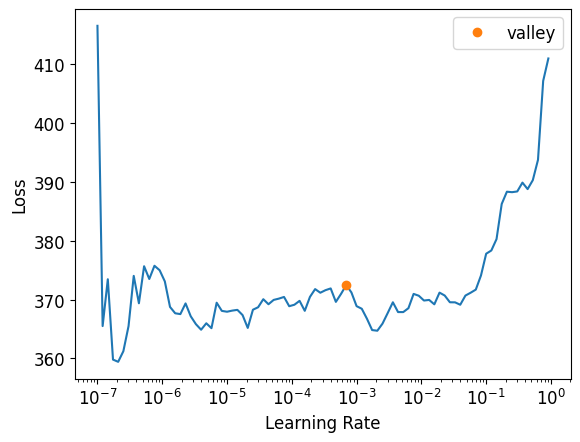

In [ ]:
# Buscar el mejor Learning Rate para el ajuste fino
lr_fine_tune = learn_fastai_head.lr_find()
print(f"Learning Rate sugerido: valley={lr_fine_tune.valley}")


### **Entrenamiento con Fine-tuning**


epoch,train_loss,valid_loss,mae,_rmse,time
0,371.340942,352.675110,16.382669,18.870287,00:17
1,371.912445,352.603851,16.336950,18.819571,00:15
2,371.037323,352.511780,16.278988,18.731852,00:15
3,370.870361,352.407166,16.315662,18.740364,00:14
4,369.567261,352.421417,16.306238,18.736313,00:14
5,369.766571,352.594360,16.259970,18.745085,00:14
6,369.263641,352.473694,16.348646,18.779200,00:14
7,370.063354,352.475067,16.357969,18.755789,00:14
8,370.006836,352.478882,16.232260,18.719404,00:14


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Better model found at epoch 0 with valid_loss value: 352.67510986328125.


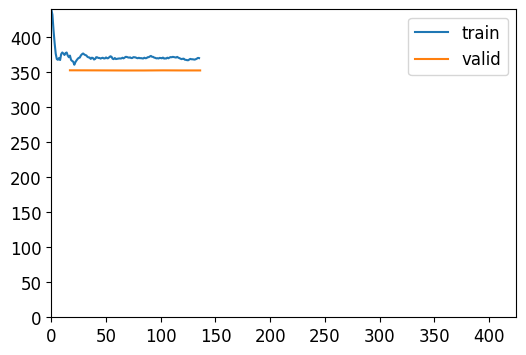

Better model found at epoch 1 with valid_loss value: 352.6038513183594.
Better model found at epoch 2 with valid_loss value: 352.51177978515625.
Better model found at epoch 3 with valid_loss value: 352.40716552734375.
No improvement since epoch 3: early stopping


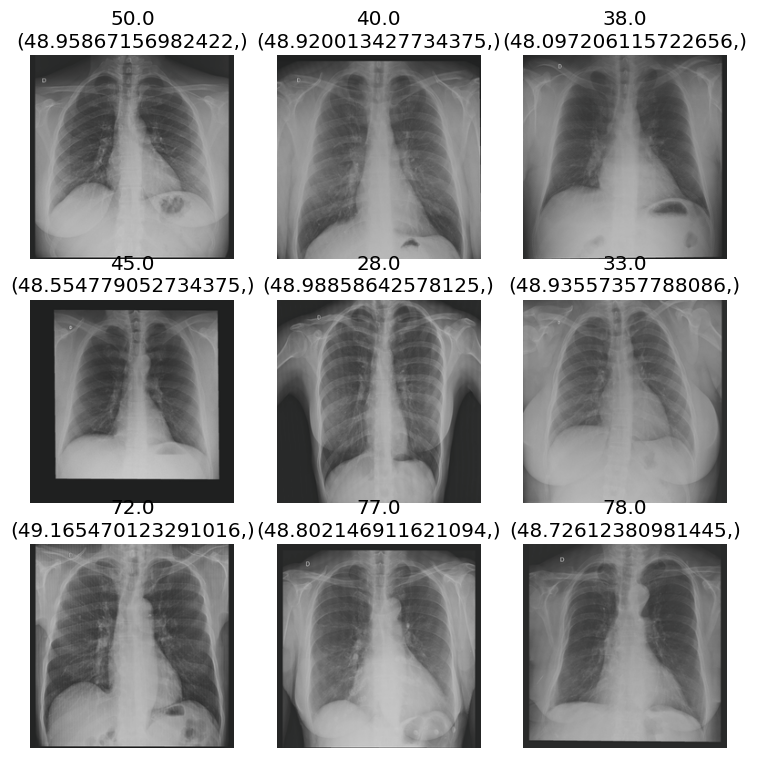

In [ ]:
# Configurar los callbacks
cbs = [
    SaveModelCallback(),  # Guardar el mejor modelo
    ShowGraphCallback(),  # Mostrar gráficos del entrenamiento
    EarlyStoppingCallback(monitor='valid_loss', patience=5)  # Detener si no hay mejora
]

# Entrenar el modelo con ajuste fino
learn_fastai_head.fit_one_cycle(
    25,  # Número de épocas
    lr_max=slice(lr_fine_tune.valley / 10, lr_fine_tune.valley),  # Learning Rate sugerido
    cbs=cbs
)

# Mostrar resultados del entrenamiento
learn_fastai_head.show_results()


### **Análisis de Resultados**
- Evaluamos el modelo con las siguientes métricas:
  - **MSE (Mean Squared Error)**.
  - **MAE (Mean Absolute Error)**.
  - **RMSE (Root Mean Squared Error)**.
  - **R² (Coefficient of Determination)**.


In [ ]:
# Validar en el conjunto de validación
preds, targs = learn_fastai_head.get_preds()
results = learn_fastai_head.validate()

# Extraer métricas
mse_final = results[0]  # MSE
mae_final = results[1]  # MAE
rmse_final = results[2]  # RMSE
r2_final = r2_score(targs.numpy(), preds.numpy())  # R²

# Imprimir resultados finales
print(f"MSE Final: {mse_final:.4f}")
print(f"MAE Final: {mae_final:.4f}")
print(f"RMSE Final: {rmse_final:.4f}")
print(f"R² Final (Validation Set): {r2_final:.4f}")


MSE Final: 352.4072
MAE Final: 16.3157
RMSE Final: 18.7404
R² Final (Validation Set): 0.0031


**Resultados:**
- MSE: 352.4072
- MAE: 16.3157
- RMSE: 18.7404
- R²: 0.0031

**Comentarios:**
- Este enfoque logra los mejores resultados, aunque la mejora frente al Apartado 1 es mínima.
- Ajustar toda la red permite adaptar los bloques convolucionales preentrenados a las características del problema.
- R² positivo sugiere un ligero ajuste, pero aún es cercano a 0, lo que indica que el modelo podría mejorar.

**Ventajas:**
- Utiliza información preentrenada y la adapta al problema.
- Mejor equilibrio entre costo computacional y rendimiento.

**Desventajas:**
- Requiere más recursos computacionales que entrenar solo la cabecera.
---


## <font color='blue'>Conclusiones. ¿Qué conclusiones se pueden extraer en base a toda la experimentación anterior? En caso de que nos enfrentemos a un nuevo problema, ¿qué opción, u opciones, de entre las anteriores, parece a priori la más razonable? ¿Por qué?

# **Mega Comparativa de Resultados**

| Apartado          | MSE      | MAE      | RMSE     | R²      | Ventajas Clave                                | Desventajas Clave                           |
|--------------------|----------|----------|----------|----------|-----------------------------------------------|---------------------------------------------|
| **1: Desde Cero**  | 352.34   | 16.33    | 18.77    | 0.0005   | Modelo totalmente adaptado                    | Altos requisitos computacionales            |
| **2: Cabecera**    | 364.33   | 16.83    | 19.33    | -0.0609  | Bajo costo computacional                      | R² negativo; bloque convolucional no ajustado |
| **3: fastai Head** | 352.76   | 16.38    | 18.88    | -0.0119  | Simplicidad con cabecera de `fastai`          | Falta de ajuste en bloques convolucionales  |
| **4: Fine-tuning** | 352.41   | 16.32    | 18.74    | 0.0031   | Mejor ajuste entre bloques y cabecera         | Mayor costo computacional                   |

---



# **Conclusiones**

### **En base a los Resultados**

1. **Mejor Opción Basada en Métricas**:
   - El **Apartado 4 (Fine-tuning)** ofrece los mejores resultados, aunque la mejora respecto al Apartado 1 (entrenar desde cero) es mínima.
   - Sin embargo, el ajuste fino permite utilizar información previa, lo que puede ser más efectivo en problemas complejos con menos datos.

2. **Alternativa Razonable**:
   - Si los recursos computacionales son limitados, el **Apartado 1** es una alternativa razonable, ya que evita las dependencias de un modelo preentrenado, aunque a un mayor costo computacional.

3. **Descartes**:
   - Los Apartados 2 y 3 (entrenar solo la cabecera) no logran capturar suficiente información del problema, como lo reflejan los valores negativos de R² en ambos casos.

### **En la Práctica (Vida Real)**

1. **Mejor Opción General**:
   - **Fine-tuning (Apartado 4)** es ampliamente usado en problemas reales:
     - Es eficiente en términos de tiempo y recursos.
     - Permite aprovechar el conocimiento previo de modelos preentrenados, adaptándolo al problema específico.

2. **Factores Decisivos en la Vida Real**:
   - **Disponibilidad de Datos**:
     - Si se dispone de pocos datos, **fine-tuning** es casi siempre la opción más razonable.
     - Entrenar desde cero, como en el Apartado 1, requiere grandes cantidades de datos para evitar el sobreajuste.
   - **Requerimientos Computacionales**:
     - Entrenar desde cero puede ser inalcanzable sin hardware de alto rendimiento.
     - Entrenar solo la cabecera (Apartados 2 y 3) puede ser útil si el problema es similar al dominio de preentrenamiento.

3. **Estrategias Híbridas**:
   - En la práctica, los proyectos suelen comenzar entrenando solo la cabecera (Apartados 2 o 3) como punto de partida rápido.
   - Si los resultados son insuficientes, se realiza un ajuste fino (Apartado 4).

---



# **Respuesta a la Pregunta**

---

### **Conclusiones Basadas en los Resultados**

1. **Mejor opción según los resultados obtenidos**:
   - El **Apartado 4 (Fine-tuning)** es la estrategia más efectiva en este caso. Permite un buen equilibrio entre aprovechamiento de características preentrenadas y ajuste a los datos específicos del problema, logrando el mejor rendimiento entre las opciones probadas.
   - Métricas obtenidas en el Apartado 4:
     - **MSE**: 352.41
     - **MAE**: 16.32
     - **RMSE**: 18.74
     - **R²**: 0.0031 (positivo, aunque bajo).

2. **Opción razonable como alternativa**:
   - Si no se dispone de los recursos para realizar un ajuste fino completo, el **Apartado 1 (entrenar desde cero)** es una alternativa viable, ya que logra un rendimiento similar, pero con un mayor costo computacional.

3. **Opciones descartadas**:
   - Los Apartados 2 y 3 (entrenar solo la cabecera) no son recomendables en este caso, ya que no logran capturar suficientes patrones relevantes del problema (R² negativo en ambos casos).

---

### **Conclusiones Basadas en la Vida Real**

1. **Estrategias utilizadas en problemas reales**:
   - En la práctica, el **fine-tuning (Apartado 4)** es la estrategia más utilizada para problemas similares:
     - Aprovecha la potencia de los modelos preentrenados como ResNet50.
     - Es eficiente en términos computacionales y de tiempo.
     - Puede ofrecer un buen rendimiento incluso con datasets relativamente pequeños.

2. **Por qué no entrenar desde cero**:
   - Entrenar desde cero, como en el Apartado 1, requiere una cantidad significativa de datos etiquetados y recursos computacionales elevados.
   - Aunque puede ser útil para problemas completamente diferentes al dominio del modelo preentrenado, no es común en aplicaciones prácticas.

3. **Cuándo entrenar solo la cabecera**:
   - Entrenar solo la cabecera (Apartados 2 y 3) puede ser una buena estrategia inicial cuando:
     - Hay limitaciones de tiempo o recursos computacionales.
     - Se espera que las características preentrenadas sean altamente relevantes para el problema (lo que no ocurrió aquí).

---

### **De cara a Nuevos Problemas**

1. **Opción más razonable**:
   - El **fine-tuning (Apartado 4)** es la mejor estrategia para la mayoría de los problemas, ya que combina:
     - Uso eficiente de modelos preentrenados.
     - Adaptación específica al problema.
   - Es la opción más equilibrada en términos de rendimiento y costo computacional.

2. **En problemas con recursos limitados**:
   - Entrenar solo la cabecera (Apartados 2 o 3) puede ser un punto de partida razonable.
   - Si los resultados no son satisfactorios, se puede pasar al ajuste fino.

3. **En problemas con muchos datos y recursos**:
   - Entrenar desde cero (Apartado 1) puede ser interesante para explorar modelos completamente personalizados.
   - Esta estrategia es menos común y solo se justifica en casos donde el dominio es muy diferente de las bases preentrenadas, o cuando se busca investigación avanzada.

---
